<a href="https://colab.research.google.com/github/jbsher/capstone/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brody Sherwood

## Capstone: Hagrid Hand Gesture Recognition

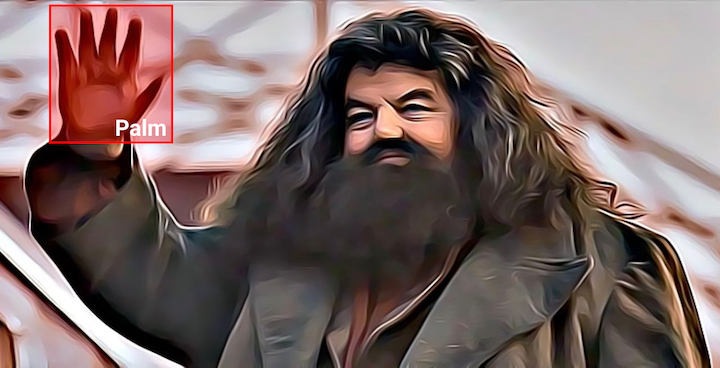

In [ ]:
!pip install torchmetrics
!pip install tensorboardX
!pip install tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00


---
# Imports

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import os
import math
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pickle
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import tensorflow as tf
import urllib
import torch

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import models, transforms, ops
from torchvision.transforms import functional as F, ToTensor, Normalize
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from torch import nn, optim, cuda
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from typing import Tuple
from ipywidgets import interact
from IPython.display import Image as DImage


**Read in**

Note: This dataset is a subset of 1000 images per category that was taken from a much larger dataset.

In [ ]:
class_names = [
   'call',
   'dislike',
   'fist',
   'four',
   'like',
   'mute',
   'ok',
   'one',
   'palm',
   'peace_inverted',
   'peace',
   'rock',
   'stop_inverted',
   'stop',
   'three',
   'three2',
   'two_up',
   'two_up_inverted',
   ]

FORMATS = (".jpg")

transform = transforms.ToTensor()

# Paths to data
path_to_train = "/content/drive/MyDrive/capstone/data/train_val"
path_to_test = "/content/drive/MyDrive/capstone/data/test_"
path_to_annotations = '/content/drive/MyDrive/capstone/data/ann_train/'
path_to_subset_annotations = '/content/drive/MyDrive/capstone/data/ann_train_subset/'
path_to_test_annotations = '/content/drive/MyDrive/capstone/data/ann_test/'

---
# EDA

**Preprocessor and import functions.**

In [ ]:
# Preprocesser function
def preprocess_image_tf(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [320, 320])
    img = (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2
    return img

In [ ]:
def load_json_for_category(category, path_to_data):
    json_filepath = os.path.join(path_to_data, f"{category}.json")

    with open(json_filepath, 'r') as json_file:
        data = json.load(json_file)

    return data

def filter_json_by_images(json_data, available_images):
    return {uuid: meta for uuid, meta in json_data.items() if f"{uuid}.jpg" in available_images}


In [ ]:
image_path_dict = {}
for category in class_names:
    category_folder = os.path.join(path_to_train, category)
    for filename in os.listdir(category_folder):
        if filename.endswith('.jpg'):
            uuid = filename.split('.')[0]
            image_path_dict[uuid] = os.path.join(category_folder, filename)

json_by_category = {category: load_json_for_category(category, path_to_annotations) for category in class_names}

combined_json_data = []
for category in class_names:
    for img_uuid, metadata in json_by_category[category].items():
        image_filepath = image_path_dict.get(img_uuid, None)
        if image_filepath:
            combined_json_data.append(((category, img_uuid), metadata))

filepaths = [image_path_dict[item[0][1]] for item in combined_json_data if item[0][1] in image_path_dict]
metadata_list = [{'bboxes': item[1]['bboxes'], 'labels': item[1]['labels']} for item in combined_json_data if item[0][1] in image_path_dict]


In [ ]:
subset_annotations = {category: {} for category in class_names}
for (category, uuid), metadata in combined_json_data:
    subset_annotations[category][uuid] = metadata

if not os.path.exists(path_to_subset_annotations):
    os.makedirs(path_to_subset_annotations)

for category, annotations in subset_annotations.items():
    with open(os.path.join(path_to_subset_annotations, f"{category}.json"), "w") as file:
        json.dump(annotations, file)


In [ ]:
#data = {}
#for category in class_names:
#    files_in_category = os.listdir(os.path.join(path_to_train, category))
#     category_uuids = [os.path.splitext(filename)[0] for filename in files_in_category if filename.endswith('.jpg')]
#     data[category] = category_uuids

# uuids_df = pd.DataFrame.from_dict(data, orient='index').transpose()


In [ ]:
# master_data = []

# for (category, uuid), metadata in combined_json_data:
#     data_point = {
#         'category': category,
#         'uuid': uuid,
#         'image_path': image_path_dict[uuid],
#         'label': metadata['labels'][0],  # Assuming one label per image
#         'bbox': metadata['bboxes']
#     }
#     master_data.append(data_point)

# master_df = pd.DataFrame(master_data)


In [ ]:
# Load image from file path
def load_image_from_filepath(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_average_rgb(image):
    return np.mean(image, axis=(0, 1))

avg_rgb_by_category = {}

# Initialize category data
for category in class_names:
    avg_rgb_by_category[category] = []

for (category, img_uuid), meta in combined_json_data:
    # Use image_path_dict to get the correct path
    image_path = image_path_dict.get(img_uuid)
    if image_path:  # Ensure the path exists
        image = load_image_from_filepath(image_path)
        avg_rgb = get_average_rgb(image)
        avg_rgb_by_category[category].append(avg_rgb)

for category in avg_rgb_by_category:
    avg_rgb_by_category[category] = np.mean(avg_rgb_by_category[category], axis=0)


In [ ]:
# Saving 'avg_rgb_by_category' to a pickle file
with open('/content/drive/MyDrive/capstone/data/avg_rgb_by_category.pkl', 'wb') as file:
    pickle.dump(avg_rgb_by_category, file)


In [ ]:
def plot_rgb_for_subset(categories_subset, subset_number):
    avg_rgb_subset = [avg_rgb_by_category[cat] for cat in categories_subset]

    # Create table data
    table_data = [['Category', 'Avg Red', 'Avg Green', 'Avg Blue']]
    for cat, rgb in zip(categories_subset, avg_rgb_subset):
        table_data.append([cat, round(rgb[0], 2), round(rgb[1], 2), round(rgb[2], 2)])

    # Create the table figure
    fig = ff.create_table(table_data, height_constant=60)

    # Bar chart data
    avg_red = [round(rgb[0], 2) for rgb in avg_rgb_subset]
    avg_green = [round(rgb[1], 2) for rgb in avg_rgb_subset]
    avg_blue = [round(rgb[2], 2) for rgb in avg_rgb_subset]

    # Create bar chart traces
    trace1 = go.Bar(x=categories_subset, y=avg_red, xaxis='x2', yaxis='y2', marker=dict(color='#AB3640'), name='Avg Red')
    trace2 = go.Bar(x=categories_subset, y=avg_green, xaxis='x2', yaxis='y2', marker=dict(color='#C7D01D'), name='Avg Green')
    trace3 = go.Bar(x=categories_subset, y=avg_blue, xaxis='x2', yaxis='y2', marker=dict(color='#7E7ED8'), name='Avg Blue')

    # Add bar chart traces to the figure
    fig.add_traces([trace1, trace2, trace3])

    # Initialize xaxis2 and yaxis2
    fig['layout']['xaxis2'] = {}
    fig['layout']['yaxis2'] = {}

    # Edit layout for subplots
    fig.layout.yaxis.update({'domain': [0, .45]})
    fig.layout.yaxis2.update({'domain': [.6, 1]})
    fig.layout.yaxis2.update({'anchor': 'x2'})
    fig.layout.xaxis2.update({'anchor': 'y2'})
    fig.layout.yaxis2.update({'title': 'RGB Values'})


    fig.layout.margin.update({'t': 75, 'l': 50})
    fig.layout.update({'title': f'Average RGB values for Categories ({subset_number})'})

    # Adjust the height
    fig.layout.update({'height': 800})

    # Display the plot
    fig.show()

all_categories = list(avg_rgb_by_category.keys())
for i in range(0, len(all_categories), 6):
    subset = all_categories[i:i+6]
    plot_rgb_for_subset(subset, f"{i+1}-{i+len(subset)}")


NOTE: The colors chosen for plotting were tested on simulators of all kinds of colorblindess to ensure readability.

https://www.color-blindness.com/coblis-color-blindness-simulator/

In [ ]:
# Retrieve the top categories based on average color values
def top_categories_for_color(color_index, n=3):
    sorted_categories = sorted(avg_rgb_by_category.items(),
                               key=lambda x: x[1][color_index],
                               reverse=True)
    return [cat[0] for cat in sorted_categories[:n]]

top_red = top_categories_for_color(0)
top_green = top_categories_for_color(1)
top_blue = top_categories_for_color(2)

unique_top_categories = list(set(top_red + top_green + top_blue))

plot_rgb_for_subset(unique_top_categories, "Top Categories by RGB")

***'two_up'*** has the highest average **Red**, with ***'call'*** having both the highest average **Green** and **Blue.**





Lets take a look at some sample images as well as their rgb color characteristics.

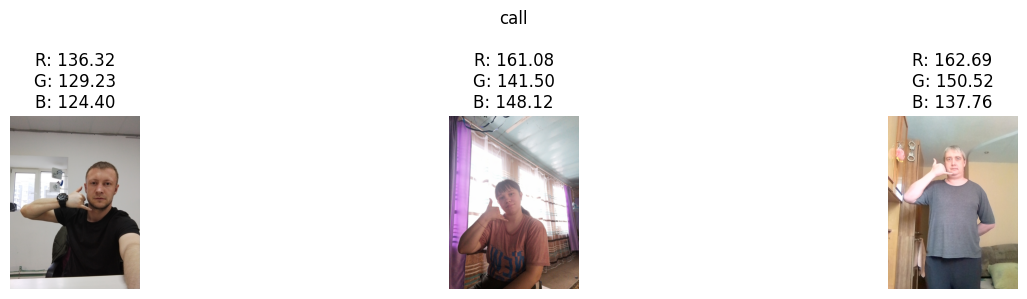

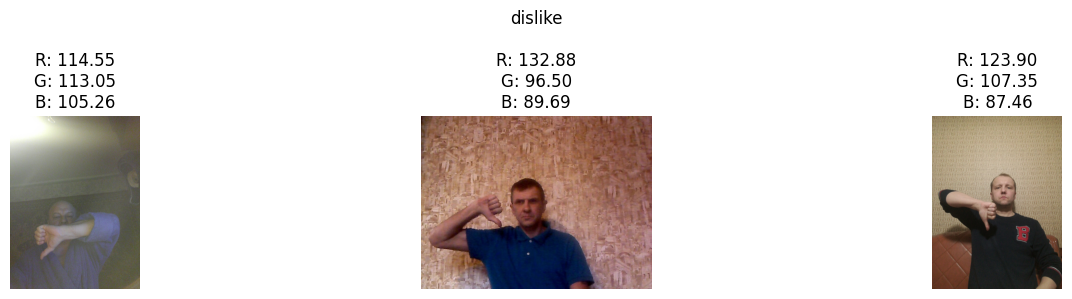

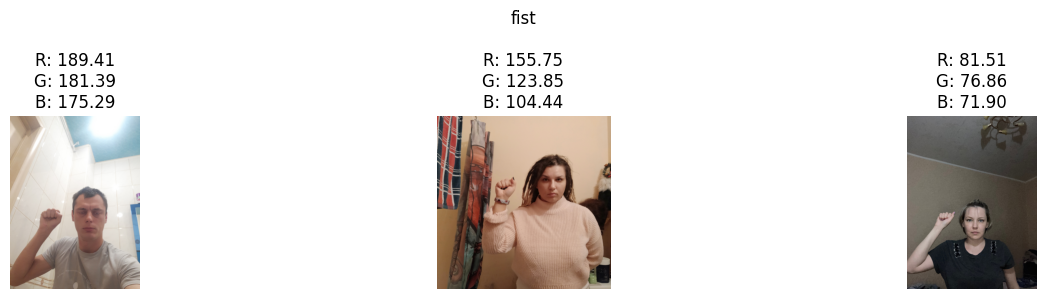

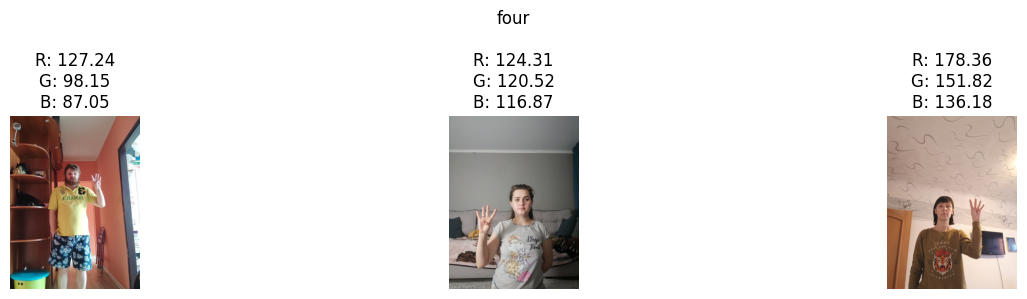

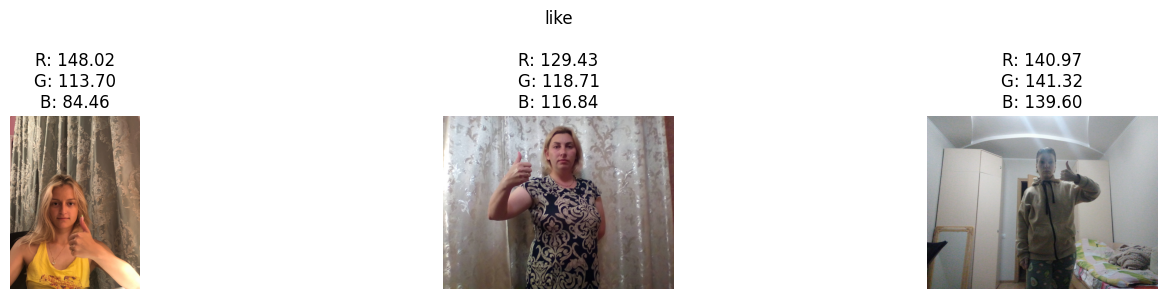

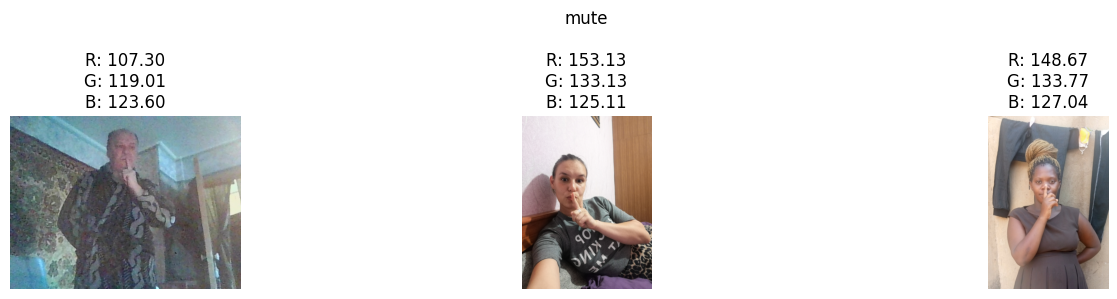

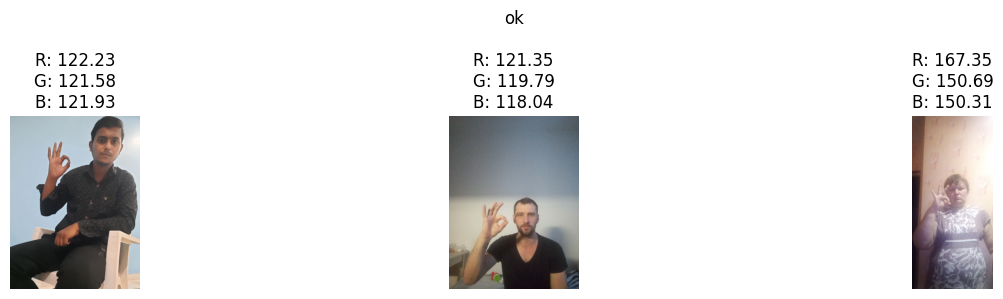

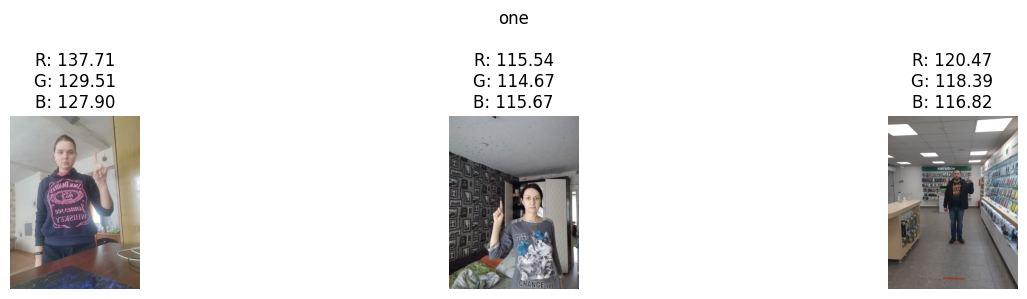

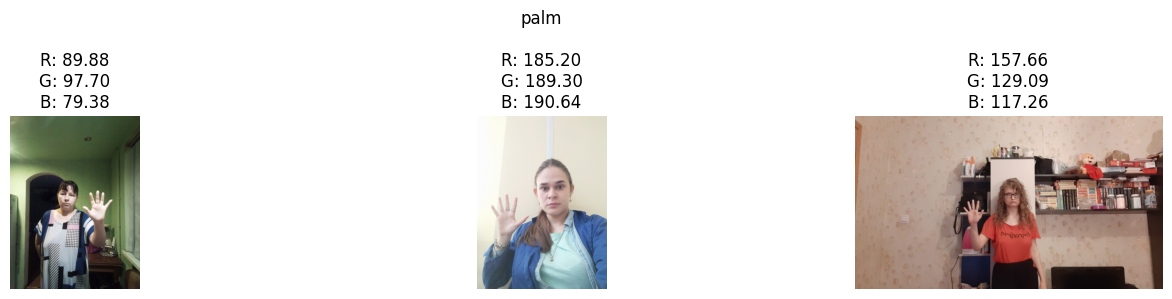

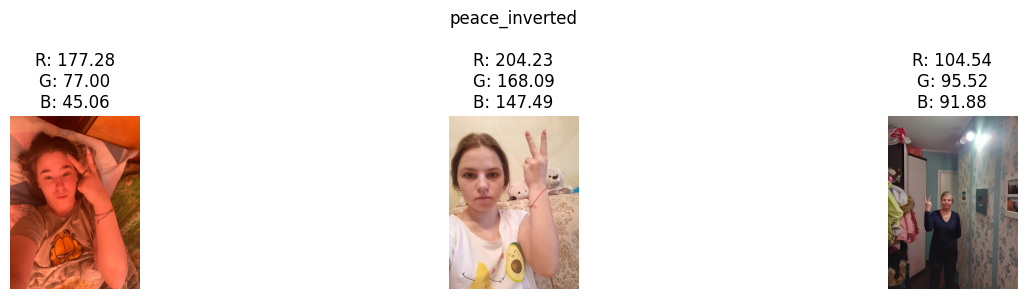

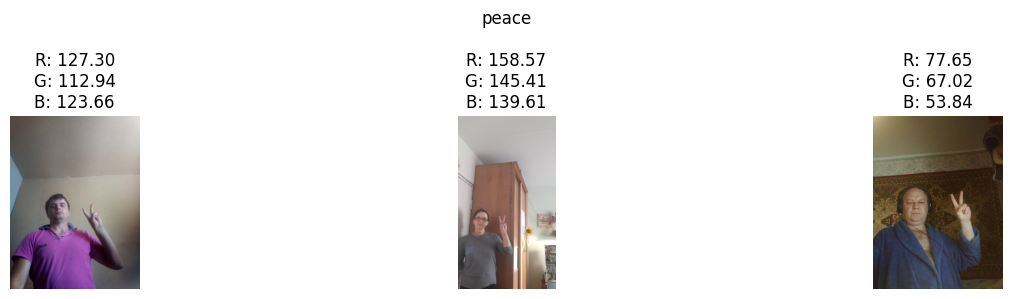

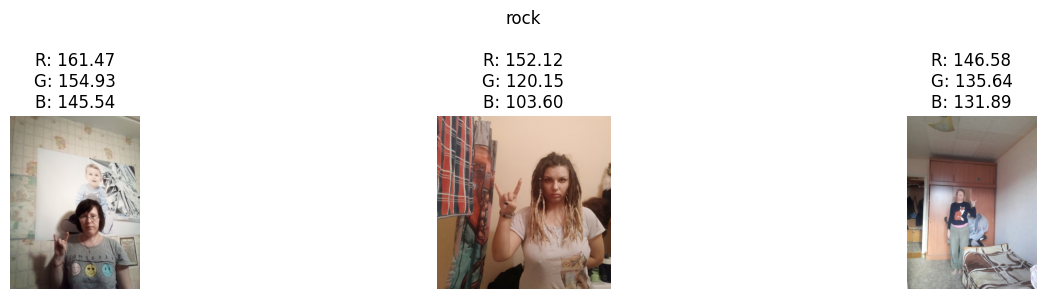

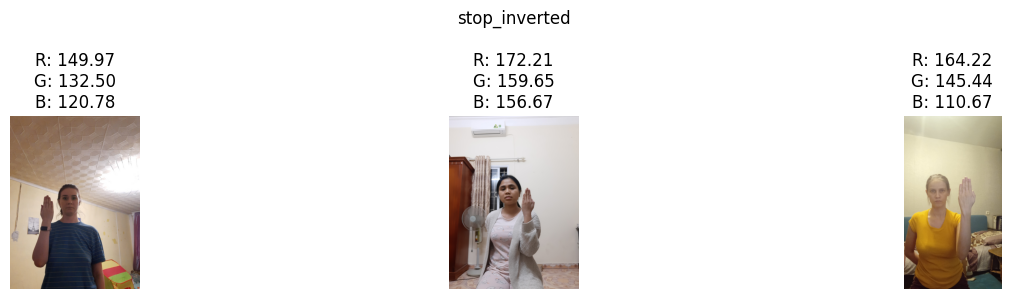

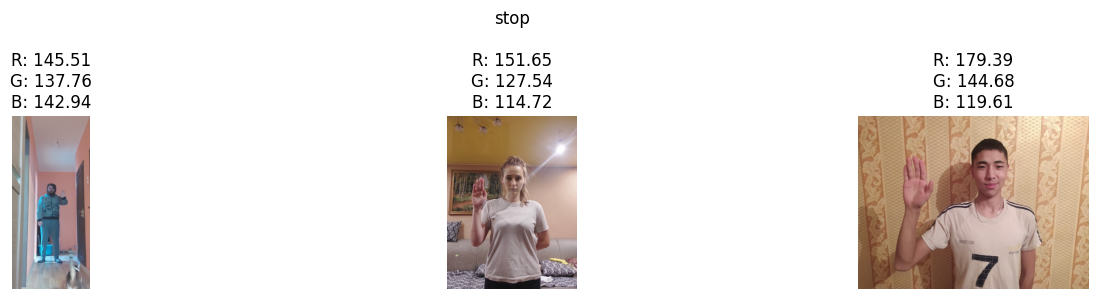

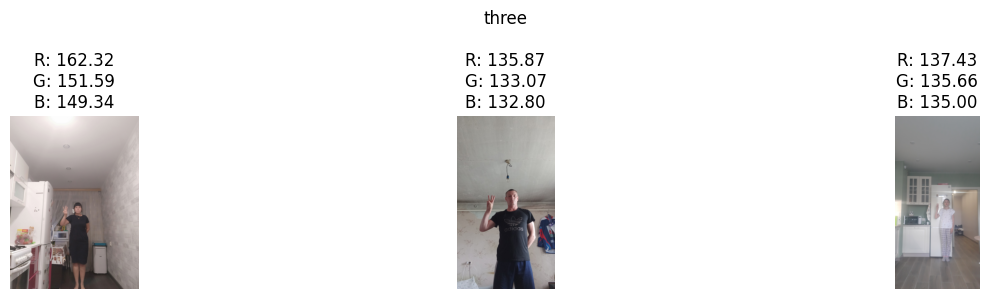

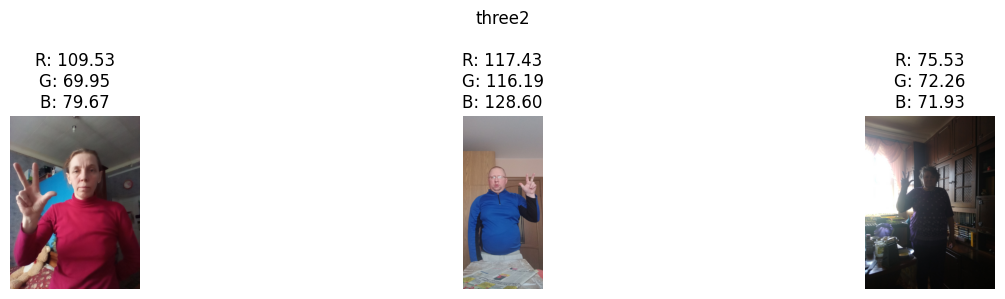

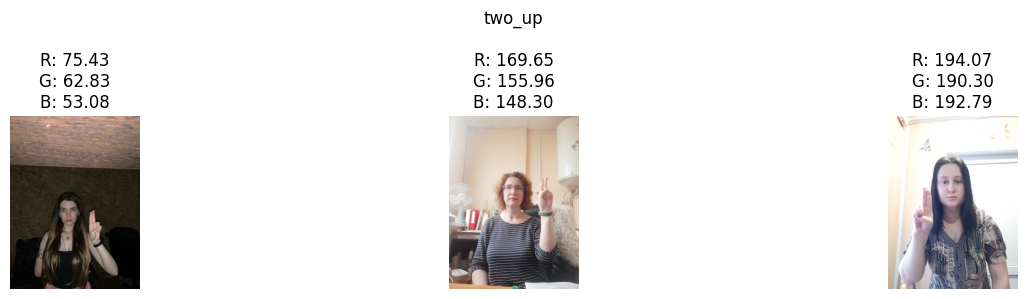

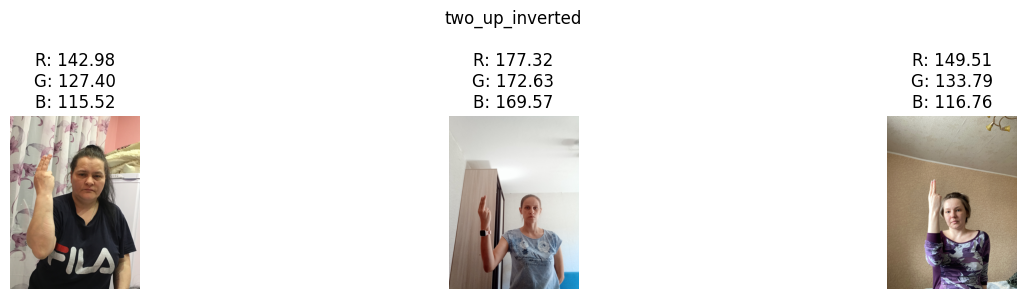

In [ ]:
# Display sample images with their average RGB values
def display_sample_images_with_rgb(data, num_samples=3):
    # Group data by category
    data_by_category = {}
    for (category, img_uuid), _ in data:
        if category not in data_by_category:
            data_by_category[category] = []
        data_by_category[category].append(img_uuid)

    for category, uuids in data_by_category.items():
        sample_uuids = np.random.choice(uuids, num_samples, replace=False)
        sample_filepaths = [os.path.join(path_to_train, category, f"{uuid}.jpg") for uuid in sample_uuids]

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        fig.suptitle(category)

        for ax, filepath in zip(axes, sample_filepaths):
            img = load_image_from_filepath(filepath)
            avg_rgb = get_average_rgb(img)

            ax.imshow(img)
            ax.set_title(f"R: {avg_rgb[0]:.2f}\nG: {avg_rgb[1]:.2f}\nB: {avg_rgb[2]:.2f}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

display_sample_images_with_rgb(combined_json_data)

Many of these images were either very dark, pixelated, or the person in the picture is far away, making it difficult to make out the hand sign. For this reason, I *increased* the image resolution from **128** **x** **128** to **320** **x** **320** for more detail during modeling. The model that we want to use wants images in this size. Seen above are the latter images.

Visualizing landmarks and bounding boxes

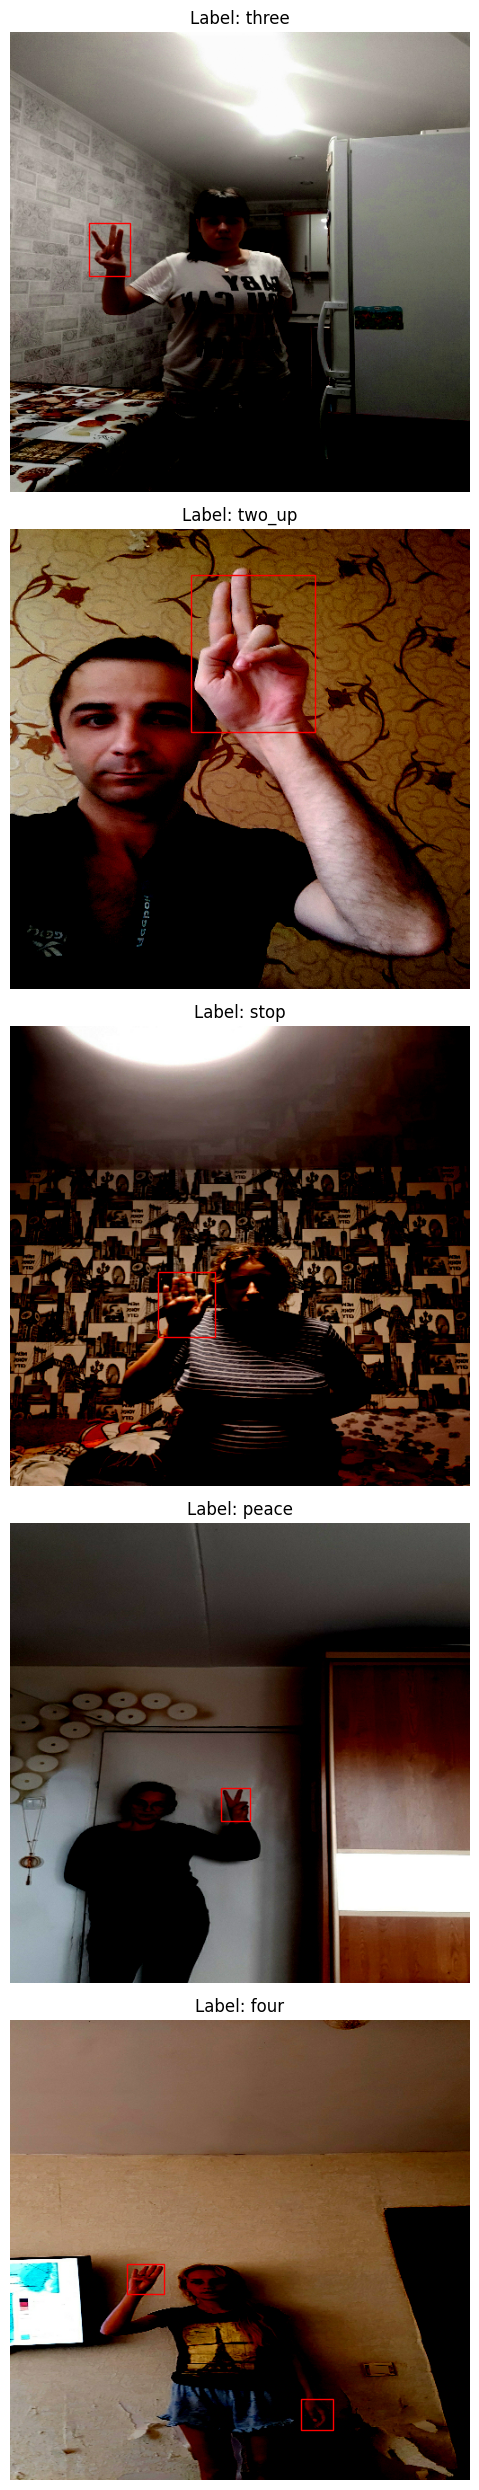

In [ ]:
def visualize_data_with_bboxes(dataset, num_samples=5):

    fig, axs = plt.subplots(num_samples, figsize=(5, 25))

    # Extract a batch from the dataset
    for batch in dataset.take(1):  # Only taking one batch for visualization
        images, labels, bboxes_batch = batch

        # Randomly select data samples from the batch
        sample_indices = np.random.choice(len(images), num_samples, replace=False)

        for i, idx in enumerate(sample_indices):
            img = images[idx].numpy()
            bboxes = bboxes_batch[idx].numpy()


            axs[i].imshow(img)
            title_text = f"Label: {labels[idx].numpy().decode('utf-8')}"
            axs[i].set_title(title_text)

            # Draw bounding boxes
            for bbox in bboxes:
                if np.any(bbox):  # Check if the bounding box is not [0,0,0,0] (padded value)
                    x, y, width, height = bbox[0] * img.shape[1], bbox[1] * img.shape[0], bbox[2] * img.shape[1], bbox[3] * img.shape[0]
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    axs[i].add_patch(rect)

            axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the data
visualize_data_with_bboxes(dataset)


Bounding boxes look to be where they shoud be. Image with two bboxes is also showing correctly, so we can move forward

##**Bounding Box Distribution**

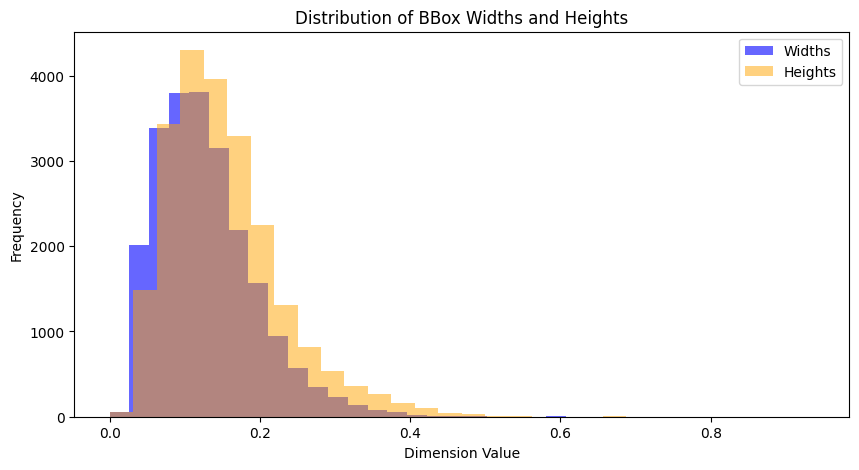

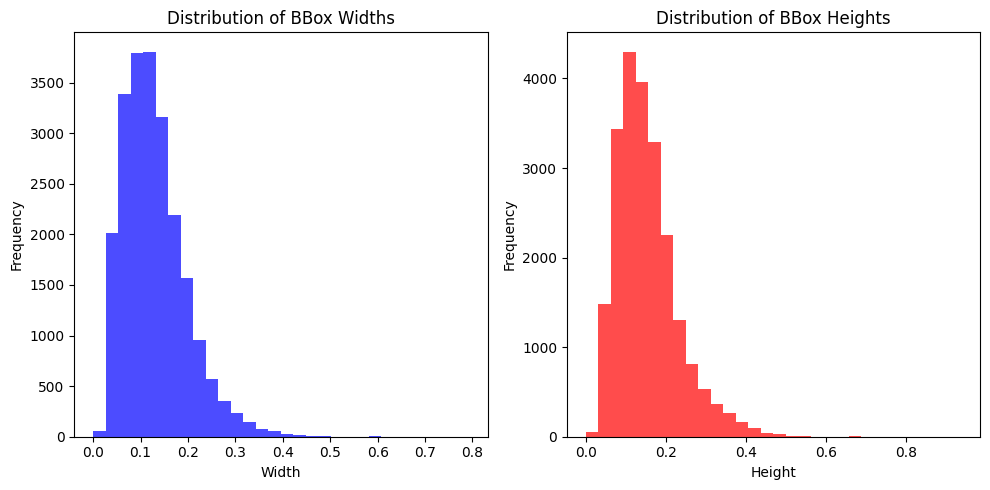

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(bbox_widths, bins=30, color='blue', alpha=0.6, label='Widths')
plt.hist(bbox_heights, bins=30, color='orange', alpha=0.5, label='Heights')

plt.title('Distribution of BBox Widths and Heights')
plt.xlabel('Dimension Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

bbox_widths = []
bbox_heights = []

for entry in combined_json_data:
    bboxes = entry[1]['bboxes']
    for bbox in bboxes:
        x, y, w, h = bbox
        bbox_widths.append(w)
        bbox_heights.append(h)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(bbox_widths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of BBox Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(bbox_heights, bins=30, color='red', alpha=0.7)
plt.title('Distribution of BBox Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Unsurprisingly, boundary box height is generally larger than its width. This makes sense with most hand gestures.

## **Bounding Box Heatmap**

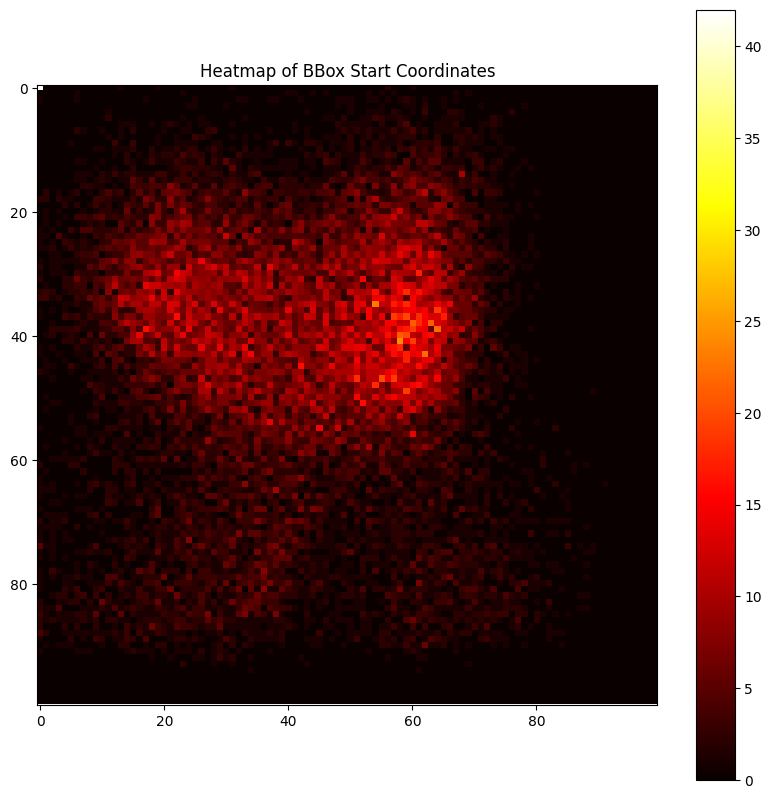

In [ ]:
heatmap = np.zeros((100, 100))

for entry in combined_json_data:
    bboxes = entry[1]['bboxes']
    for bbox in bboxes:
        x, y, _, _ = [int(coord * 99) for coord in bbox]  # Multiplying by 99 to fit our heatmap size
        heatmap[y, x] += 1

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='hot')
plt.colorbar()
plt.title('Heatmap of BBox Start Coordinates')
plt.show()


Hot spots are evident in two locations, upper middle left and upper middle right. If you look below it appears that ther are two smaller hot spots directly beneath them.  This suggests that subjects are in the middle of the frame and their gestures are help up or down by either their left or right hand.

**Leading Hand in Picture**

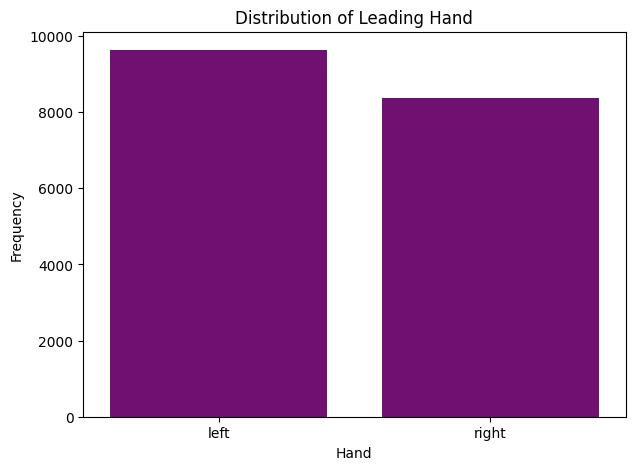

In [ ]:
# Extract leading hands
leading_hands = [entry[1]['leading_hand'] for entry in combined_json_data]

# Create the countplot
plt.figure(figsize=(7, 5))
sns.countplot(x=leading_hands, color="purple")
plt.title('Distribution of Leading Hand')
plt.xlabel('Hand')
plt.ylabel('Frequency')
plt.show()

Left handed forward has a large number more images than right.

## **Distance Between Landmarks**

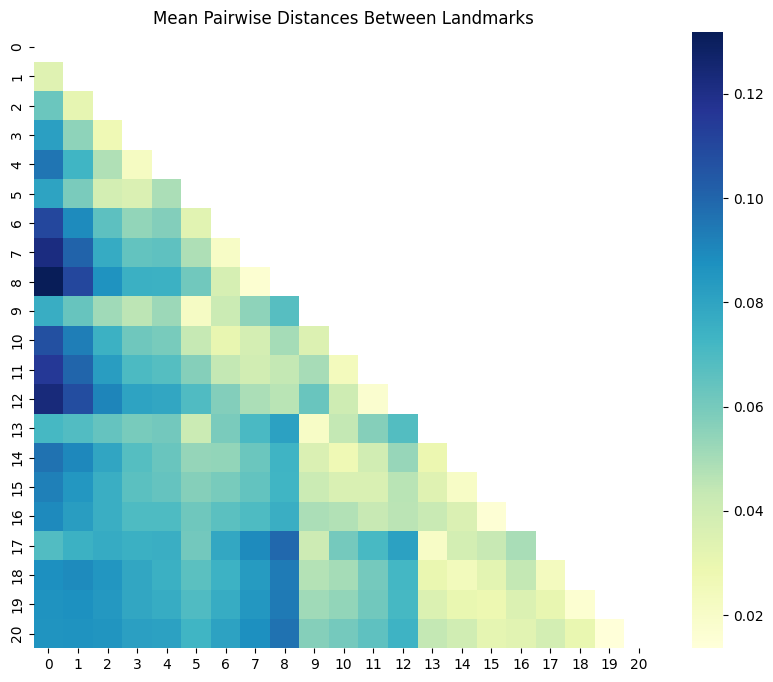

In [ ]:
def compute_pairwise_distances(landmarks):
    num_landmarks = len(landmarks)
    distances = np.zeros((num_landmarks, num_landmarks))

    for i in range(num_landmarks):
        for j in range(num_landmarks):
            # Convert landmarks to numpy arrays
            lm1 = np.array(landmarks[i])
            lm2 = np.array(landmarks[j])

            # Euclidean distance
            if lm1.shape == lm2.shape:
                dist = np.linalg.norm(lm1 - lm2)
                distances[i, j] = dist

    return distances

# Compute mean distances
total_distances = np.mean([compute_pairwise_distances(lm) for lm in all_landmarks], axis=0)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(total_distances, dtype=bool))

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(total_distances, cmap="YlGnBu", mask=mask)
plt.title('Mean Pairwise Distances Between Landmarks')
plt.show()


Lighter blocks are where landmarks are close to each other, with the center being the distance to itself. Respectively, darker spots indicate larger distances between landmarks. This makes sense, since we see some darker spots towards the edges and lighter clusters towards the middle. This confirms that our data is looking as expected.

In [ ]:
# Extract bounding box sizes
bbox_areas = [w*h for entry in combined_json_data for _, _, w, h in entry[1]['bboxes']]

mean_area = np.mean(bbox_areas)
std_area = np.std(bbox_areas)
threshold_upper = mean_area + 3 * std_area
threshold_lower = mean_area - 3 * std_area

# Images with outlier bounding boxes
outliers_large = [entry for entry in combined_json_data if any(w*h > threshold_upper for _, _, w, h in entry[1]['bboxes'])]
outliers_small = [entry for entry in combined_json_data if any(w*h < threshold_lower for _, _, w, h in entry[1]['bboxes'])]

print(f"Mean bounding box area: {mean_area:.2f}")
print(f"Standard deviation of bounding box area: {std_area:.2f}")
print(f"Upper threshold: {threshold_upper:.2f}")
print(f"Lower threshold: {threshold_lower:.2f}")
print(f"Number of images with bounding boxes larger than the threshold: {len(outliers_large)}")
print(f"Number of images with bounding boxes smaller than the threshold: {len(outliers_small)}")

Mean bounding box area: 0.02
Standard deviation of bounding box area: 0.02
Upper threshold: 0.09
Lower threshold: -0.05
Number of images with bounding boxes larger than the threshold: 391
Number of images with bounding boxes smaller than the threshold: 0


Only 391 bounding boxes outside of the threshold out of 18,000 seems pretty acceptable.

In [ ]:
num_multi_bbox_images = len(multi_bbox_images)
num_no_bbox_images = len(no_bbox_images)

print(f"Number of images with multiple bounding boxes: {num_multi_bbox_images}")
print(f"Number of images with no bounding boxes: {num_no_bbox_images}")


Number of images with multiple bounding boxes: 4374
Number of images with no bounding boxes: 0


All of these with multiple will have a second hand, which will be assigned *no_gesture*.

---
# Modeling w/ TensorFlow

In [14]:
class_names = [
   'call',
   'dislike',
   'fist',
   'four',
   'like',
   'mute',
   'ok',
   'one',
   'palm',
   'peace_inverted',
   'peace',
   'rock',
   'stop_inverted',
   'stop',
   'three',
   'three2',
   'two_up',
   'two_up_inverted',
   'no_gesture'
   ]

class GestureDataset(torch.utils.data.Dataset):

    @staticmethod
    def __get_files_from_dir(pth: str, extns: Tuple):
        if not os.path.exists(pth):
            print(f"Dataset directory doesn't exist {pth}")
            return []
        files = [f for f in os.listdir(pth) if f.endswith(extns)]
        return files

    def __read_annotations(self, path):
        annotations_all = None
        exists_images = []
        for target in class_names:
            path_to_csv = os.path.join(path, f"{target}.json")
            if os.path.exists(path_to_csv):
                json_annotation = json.load(open(
                    os.path.join(path, f"{target}.json")
                ))

                json_annotation = [dict(annotation, **{"name": f"{name}.jpg"}) for name, annotation in
                                   zip(json_annotation, json_annotation.values())]

                annotation = pd.DataFrame(json_annotation)

                annotation["target"] = target
                annotations_all = pd.concat([annotations_all, annotation], ignore_index=True)
                exists_images.extend(
                    self.__get_files_from_dir(os.path.join(self.path_images, target), FORMATS))
            else:
                if target != 'no_gesture':
                    print(f"Database for {target} not found")

        annotations_all["exists"] = annotations_all["name"].isin(exists_images)

        annotations_all = annotations_all[annotations_all["exists"]]

        users = annotations_all["user_id"].unique()
        users = sorted(users)
        random.Random(42).shuffle(users)
        train_users = users[:int(len(users) * 0.8)]
        val_users = users[int(len(users) * 0.8):]

        annotations_all = annotations_all.copy()

        if self.is_train:
            annotations_all = annotations_all[annotations_all["user_id"].isin(train_users)]
        else:
            annotations_all = annotations_all[annotations_all["user_id"].isin(val_users)]

        return annotations_all

    def __init__(self, path_annotation, path_images, is_train, transform=None):
        self.is_train = is_train
        self.transform = transform
        self.path_annotation = path_annotation
        self.path_images = path_images
        self.transform = transform
        self.labels = {label: num for (label, num) in
                       zip(class_names, range(len(class_names)))}
        self.annotations = self.__read_annotations(self.path_annotation)

    def __len__(self):
        return self.annotations.shape[0]

    def get_sample(self, index: int):
        row = self.annotations.iloc[[index]].to_dict('records')[0]
        image_pth = os.path.join(self.path_images, row["target"], row["name"])
        image = Image.open(image_pth).convert("RGB")

        labels = torch.LongTensor([self.labels[label] for label in row["labels"]])

        target = {}
        width, height = image.size

        bboxes = []

        for bbox in row["bboxes"]:
            x1, y1, w, h = bbox
            bbox_abs = [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]
            bboxes.append(bbox_abs)

        target["labels"] = labels
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float32)
        target["orig_size"] = torch.as_tensor([int(height), int(width)])

        return image, target

    def __getitem__(self, index: int):
        image, target = self.get_sample(index)
        if self.transform:
            image = self.transform(image)
        return image, target

In [15]:
def collate_fn(batch):
    batch_targets = list()
    images = list()

    for b in batch:
        images.append(b[0])
        batch_targets.append({"boxes": b[1]["boxes"],
                              "labels": b[1]["labels"]})
    return images, batch_targets

In [16]:
random_seed = 42
num_classes = len(class_names)
batch_size = 16
num_epoch = 15

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_data = GestureDataset(path_images=path_to_train,
                            path_annotation=path_to_subset_annotations,
                            is_train=True, transform=transform)

test_data = GestureDataset(path_images=path_to_test,
                            path_annotation=path_to_test_annotations,
                            is_train=False, transform=transform)

Dataset directory doesn't exist /content/drive/MyDrive/capstone/data/train_val/no_gesture


In [17]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,collate_fn=collate_fn, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,collate_fn=collate_fn, shuffle=True, num_workers=4)

In [18]:
lr = 0.005
momentum = 0.9
weight_decay = 5e-4

model = models.detection.ssdlite320_mobilenet_v3_large(num_classes=len(class_names) + 1, pretrained_backbone=True)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
warmup_factor = 1.0 / 1000
warmup_iters = min(1000, len(train_data) - 1)

lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 67.4MB/s]


In [19]:
def eval(model, test_dataloader, epoch):
    model.eval()
    with torch.no_grad():
        mapmetric = MeanAveragePrecision()

        for images, targets in test_dataloader:
            images = list(image.to(device) for image in images)
            output = model(images)

            for pred in output:
                for key, value in pred.items():
                    pred[key] = value.cpu()

            mapmetric.update(output, targets)

    metrics = mapmetric.compute()
    return metrics

In [20]:
# Troubleshooting
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
if torch.cuda.is_available():
  generator = torch.Generator('cuda').manual_seed(random_seed)
else:
  generator = torch.Generator().manual_seed(random_seed)
print(torch.cuda.device_count())

1


In [23]:
def compute_average_test_loss(model, dataloader):
    # Put the model in evaluation mode
    model.eval()
    total_test_loss = 0
    total_items = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets_device = [{k: v.to(device) for k, v in target.items()} for target in targets]

            loss_dict = model(images, targets_device)
            total_loss = sum(loss for loss in loss_dict.values())
            total_test_loss += total_loss.item()
            total_items += len(images)

    # Return average test loss
    return total_test_loss / total_items

# Initialize lists to store losses for each epoch
train_loss_values = []
test_loss_values = []

!mkdir checkpoints
save_path = "/content/drive/MyDrive/capstone/training/"

for epoch in range(num_epoch):
    model.train()
    total = 0
    sum_loss = 0
    for images, targets in tqdm(train_dataloader):
        batch = len(images)
        images = list(image.to(device) for image in images)
        targets_device = [{k: v.to(device) for k, v in target.items()} for target in targets]

        loss_dict = model(images, targets_device)
        losses = sum(loss for loss in loss_dict.values())
        loss = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        lr_scheduler_warmup.step()

        total = total + batch
        sum_loss = sum_loss + loss

    # Compute average training loss for the epoch
    avg_train_loss = sum_loss / total
    train_loss_values.append(avg_train_loss)

    # Compute average test loss
    avg_test_loss = compute_average_test_loss(model, test_dataloader)
    test_loss_values.append(avg_test_loss)

    metrics = eval(model, test_dataloader, epoch)
    print(f"epoch : {epoch}  |||  training loss : {avg_train_loss}  |||  test loss : {avg_test_loss}  |||  MAP : {metrics['map']}")

    epoch_save_path = os.path.join(save_path, f"mdl_epoch_{epoch}.pth")
    torch.save(model.state_dict(), epoch_save_path)


mkdir: cannot create directory ‘checkpoints’: File exists


100%|██████████| 871/871 [49:39<00:00,  3.42s/it]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


epoch : 0  |||  loss : 0.41942397955331245 ||| MAP : 0.2138044238090515


100%|██████████| 871/871 [04:14<00:00,  3.42it/s]


epoch : 1  |||  loss : 0.18812603460041366 ||| MAP : 0.2954833507537842


100%|██████████| 871/871 [04:17<00:00,  3.38it/s]


epoch : 2  |||  loss : 0.14101099994481722 ||| MAP : 0.30192577838897705


100%|██████████| 871/871 [04:20<00:00,  3.34it/s]


epoch : 3  |||  loss : 0.12043799630636598 ||| MAP : 0.3541274666786194


100%|██████████| 871/871 [04:17<00:00,  3.38it/s]


epoch : 4  |||  loss : 0.10583327117662406 ||| MAP : 0.3740176558494568


100%|██████████| 871/871 [04:20<00:00,  3.35it/s]


epoch : 5  |||  loss : 0.09574384713545976 ||| MAP : 0.36904627084732056


100%|██████████| 871/871 [04:19<00:00,  3.36it/s]


epoch : 6  |||  loss : 0.0875674065351144 ||| MAP : 0.3841645121574402


100%|██████████| 871/871 [04:20<00:00,  3.34it/s]


epoch : 7  |||  loss : 0.08281982396393715 ||| MAP : 0.3848445415496826


100%|██████████| 871/871 [04:19<00:00,  3.35it/s]


epoch : 8  |||  loss : 0.07885628951937516 ||| MAP : 0.3892193138599396


100%|██████████| 871/871 [04:21<00:00,  3.33it/s]


epoch : 9  |||  loss : 0.0752628229830137 ||| MAP : 0.40942952036857605


100%|██████████| 871/871 [04:21<00:00,  3.33it/s]


epoch : 10  |||  loss : 0.07040686384720464 ||| MAP : 0.385127454996109


100%|██████████| 871/871 [04:22<00:00,  3.31it/s]


epoch : 11  |||  loss : 0.0696618195592142 ||| MAP : 0.39828363060951233


100%|██████████| 871/871 [04:21<00:00,  3.34it/s]


epoch : 12  |||  loss : 0.0651552837503528 ||| MAP : 0.407426118850708


100%|██████████| 871/871 [04:18<00:00,  3.36it/s]


epoch : 13  |||  loss : 0.06284951886037558 ||| MAP : 0.3927726447582245


100%|██████████| 871/871 [04:20<00:00,  3.34it/s]


epoch : 14  |||  loss : 0.06273539219091173 ||| MAP : 0.4168335199356079


In [52]:
# Extracted loss values
loss_values = [
    0.41942397955331245, 0.18812603460041366, 0.14101099994481722, 0.12043799630636598,
    0.10583327117662406, 0.09574384713545976, 0.0875674065351144, 0.08281982396393715,
    0.07885628951937516, 0.0752628229830137, 0.07040686384720464, 0.0696618195592142,
    0.0651552837503528, 0.06284951886037558, 0.06273539219091173
]

# Extracted MAP values
map_values = [
    0.2138044238090515, 0.2954833507537842, 0.30192577838897705, 0.3541274666786194,
    0.3740176558494568, 0.36904627084732056, 0.3841645121574402, 0.3848445415496826,
    0.3892193138599396, 0.40942952036857605, 0.385127454996109, 0.39828363060951233,
    0.407426118850708, 0.3927726447582245, 0.4168335199356079
]

In [30]:
num_classes

19

In [42]:
images = []
for gesture in class_names[:-1]:
    image_path = glob(f'/content/drive/MyDrive/capstone/data/test_/{gesture}/*.jpg')[0]
    images.append(Image.open(image_path))

images_tensors = images.copy()
images_tensors_input = list(transform(image).to(device) for image in images_tensors)

with torch.no_grad():
    model.eval()
    out = model(images_tensors_input)

In [43]:
bboxes = []
scores = []
labels = []
for pred in out:
    ids = pred['scores'] >= 0.2
    bboxes.append(pred['boxes'][ids][:2].cpu().numpy().astype(np.int))
    scores.append(pred['scores'][ids][:2].cpu().numpy())
    labels.append(pred['labels'][ids][:2].cpu().numpy())

<ipython-input-43-27f700cd89d1>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bboxes.append(pred['boxes'][ids][:2].cpu().numpy().astype(np.int))


In [44]:
short_class_names = []

for name in class_names:
    if name == 'stop_inverted':
        short_class_names.append('stop inv.')
    elif name == 'peace_inverted':
        short_class_names.append('peace inv.')
    elif name == 'two_up':
        short_class_names.append('two up')
    elif name == 'two_up_inverted':
        short_class_names.append('two up inv.')
    elif name == 'no_gesture':
        short_class_names.append('no gesture')
    else:
        short_class_names.append(name)

In [45]:
final_images = []
for bbox, score, label, image in zip(bboxes, scores, labels, images):
    image = np.array(image)
    for i, box in enumerate(bbox):
        _,width,_  = image.shape
        image = cv2.rectangle(image, box[:2], box[2:], thickness=3, color=[255, 0, 255])
        cv2.putText(image, f'{short_class_names[label[i]]}: {score[i]:0.2f}', (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX,
                        width / 780, (0, 0, 255), 2)
    final_images.append(Image.fromarray(image))

In [46]:
out_dir = "out_images"
!mkdir -p {out_dir}

out_images = []
for i, image in enumerate(final_images):
    out_name = os.path.join(out_dir, f"{i}.png")
    out_images.append(out_name)
    image.save(out_name)
    import ipywidgets as widgets
from IPython.display import display

# Define a function to display images
def show_images(file):
    image_path = os.path.join(out_dir, file)
    display(DImage(image_path, width=320, height=320))

# Create a list of file names in the output directory
file_list = os.listdir(out_dir)

# Use interact to create the widget for selecting images
@widgets.interact(file=widgets.Dropdown(options=file_list))
def select_and_display_image(file):
    show_images(file)


interactive(children=(Dropdown(description='file', options=('15.png', '16.png', '5.png', '13.png', '4.png', '9…

In [59]:
all_predictions = []
all_targets = []
test_loss = 0.0

with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
        images = list(image.to(device) for image in images)
        targets_device = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Predictions
        model.eval()
        outputs = model(images)
        model.train()

        # Loss computation
        loss_dict = model(images, targets_device)
        total_loss = sum(loss for loss in loss_dict.values())
        test_loss += total_loss.item()

        # Convert outputs (predictions) and targets to CPU before appending
        outputs_cpu = [{k: v.to('cpu') for k, v in output.items()} for output in outputs]
        targets_cpu = [{k: v.to('cpu') for k, v in target.items()} for target in targets]

        all_predictions.extend(outputs_cpu)
        all_targets.extend(targets_cpu)

average_test_loss = test_loss / len(test_dataloader)
print(f"Average Test Loss: {average_test_loss}")


100%|██████████| 23/23 [00:11<00:00,  1.94it/s]

Average Test Loss: 2.632406074067821


In [48]:
print(map_score)


{'map': tensor(0.4168), 'map_50': tensor(0.6380), 'map_75': tensor(0.4645), 'map_small': tensor(0.), 'map_medium': tensor(0.1840), 'map_large': tensor(0.4464), 'mar_1': tensor(0.5186), 'mar_10': tensor(0.5620), 'mar_100': tensor(0.5669), 'mar_small': tensor(0.), 'mar_medium': tensor(0.2818), 'mar_large': tensor(0.5977), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], dtype=torch.int32)}


In [60]:
epochs = range(1, num_epoch + 1)
plt.plot(epochs, train_loss_values, 'g', label='Training loss')
plt.plot(epochs, test_loss_values, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

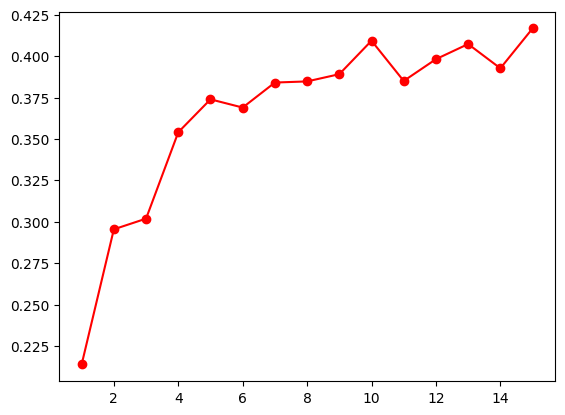

In [54]:
plt.plot(epochs, map_values, '-o', color='red', label='MAP value')


In [55]:
# For instance, if you're using the torchmetrics package to calculate mAP:
metric = MeanAveragePrecision()
map_score = metric(all_predictions, all_targets)
print(f"mAP on test set: {map_score.item()}")


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


AttributeError: ignored

In [ ]:
# Save combined_json_data
with open('/content/drive/MyDrive/capstone/data/combined_json_data.json', 'w') as f:
    json.dump(combined_json_data, f)

In [ ]:
# Image paths
with open('/content/drive/MyDrive/capstone/data/image_path_dict.json', 'w') as f:
    json.dump(image_path_dict, f)

In [ ]:
uuids_df.to_csv('/content/drive/MyDrive/capstone/data/uuids_df.csv', index=False)
master_df.to_csv('/content/drive/MyDrive/capstone/data/master_df.csv', index=False)